# Automated ML for time series predicion

We used one of the dataset in [Numenta Anomaly Benchmark (NAB)](https://github.com/numenta/NAB) for demo, i.e. NYC taxi passengers dataset, which contains 10320 records, each indicating the total number of taxi passengers in NYC at a corresonponding time spot. 

In [1]:
%load_ext autoreload
%autoreload 2

## 0. Helper function definations

In [2]:
# plot the predicted values and actual values (for the test data)
def plot_result(test_df, pred_df):
    # target column of dataframe is "value"
    # past sequence length is 50
    pred_value = pred_df["value"].values
    true_value = test_df["value"].values[50:]
    fig, axs = plt.subplots()

    axs.plot(pred_value,color='red', label='predicted values')
    axs.plot(true_value,color='blue', label='actual values')
    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel('test data index')
    plt.ylabel('number of taxi passengers')
    plt.legend(loc='upper left')
    plt.show()

## 1. load data

We have implemented load_nytaxi_data_df method to load nyc taxi data into train/val/test dataframe. You can change val_split_ratio, test_split_ratio and data_path as you want. Train/val/test dataframe all have two columns: "datetime" and "value", where "value" column is the target to predict.

In [3]:
import os
import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
%pylab inline
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [4]:
# load nyc taxi data
from zoo.automl.common.util import load_nytaxi_data_df
train_df, val_df, test_df = load_nytaxi_data_df(val_split_ratio=0.1, test_split_ratio=0.1)

In [5]:
train_df.describe()

,value
count,8256.000000
mean,15421.585514
std,6871.989592
min,1431.000000
25%,11040.000000
50%,17014.500000
75%,20032.250000
max,39197.000000


In [6]:
train_df.head(5)

,datetime,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [7]:
# shape of the dataframe
print("The shape of train_df is", train_df.shape)
print("The shape of val_df is", val_df.shape)
print("The shape of test_df is", test_df.shape)

The shape of train_df is (8256, 2)
The shape of val_df is (1032, 2)
The shape of test_df is (1032, 2)


No handles with labels found to put in legend.


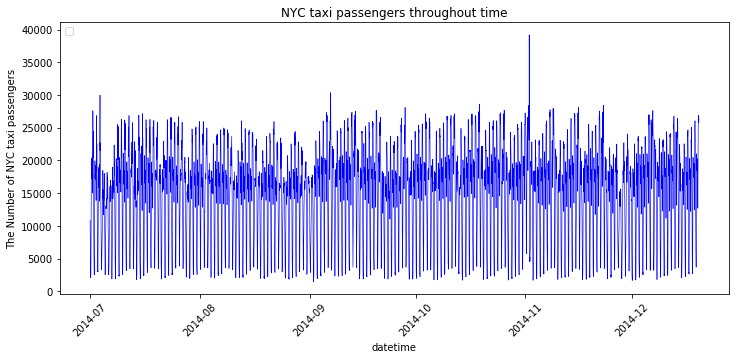

In [10]:
# visualisation of anomaly throughout time in train_df
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig, ax = plt.subplots(figsize=(12, 5))
# pd.plotting.deregister_matplotlib_converters()

ax.plot(train_df['datetime'], train_df['value'], color='blue', linewidth=0.6)
ax.set_title('NYC taxi passengers throughout time')

plt.xlabel('datetime')
plt.xticks(rotation=45) 
plt.ylabel('The Number of NYC taxi passengers')
plt.legend(loc='upper left')
plt.show()

## 2. Train and validation

You can use analytices zoo automl to predict time series data by simply define a `TimeSequencePredictor`. Currently, our automl support searching feature combinations in a predefined feature space, and searching model hyper-parameters. Model selection is not supported yet.  

We use feature tools to generate features from the given datetime. The generated features are \['HOUR', 'DAY', 'MONTH'. 'IS_AWAKE', 'IS_BUSY_HOURS'\]. Our feature space comprises these generated features as well as the original inputs such as \['datetime','value'\].  

We use a vanilla LSTM model to predict time series data. The model search space contains the unit num of lstm layers ,dropout rate and hyper-parameters for training, such as batch_size, learning rate, etc. 

Currently, We use RNN to learn from 50 previous values, and predict just the 1 next value. You can specify the sequence length to predict while creating `TimeSequencePredictor` with arg: `future_seq_len`. The previous sequence length will be  considered as a tunable variable in our future version.

In [11]:
# build time sequence predictor
from zoo.automl.regression.time_sequence_predictor import TimeSequencePredictor

# you need to specify the name of datetime column and target column
# The default names are "datetime" and "value" respectively.
tsp = TimeSequencePredictor(dt_col="datetime",
                            target_col="value",
                            extra_features_col=None)

Using TensorFlow backend.


In [13]:
%%time
# fit train_df and validate with val_df, return the best trial as pipeline.
# the default trail num is 10, need about 5.5 mins.
pipeline = tsp.fit(train_df,
                   validation_df=val_df,
                   metric="mean_squared_error")
print("Training completed.")

2019-05-29 19:48:53,610	WARNING worker.py:1341 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2019-05-29 19:48:53,611	ERROR worker.py:1347 -- Calling ray.init() again after it has already been called.
2019-05-29 19:48:53,615	INFO tune.py:60 -- Tip: to resume incomplete experiments, pass resume='prompt' or resume=True to run()
2019-05-29 19:48:53,616	INFO tune.py:223 -- Starting a new experiment.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/6 CPUs, 0/0 GPUs
Memory usage on this node: 15.7/67.4 GB

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 2/6 CPUs, 0/0 GPUs
Memory usage on this node: 15.7/67.4 GB
Result logdir: /home/shan/ray_results/train_func
Number of trials: 2 ({'RUNNING': 1, 'PENDING': 1})
PENDING trials:
 - train_func_1_dropout_2=0.49696,lstm_1_units=32,selected_features=['IS_WEEKEND(datetime)' 'MONTH(datetime)' 'IS_AWAKE(datetime)'
 'HOUR(datetime)']:	PENDING
RUNNING trials:
 - train_func_0_dropout_2=0.37939,lstm_1_units=16,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'IS_AWAKE(datetime)'
 'IS_WEEKEND(datetime)']:	RUNNING

(pid=31626) 2019-05-29 19:48:57.107849: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
(pid=31632) 2019-05-29 19:48:57.102268: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your C

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/6 CPUs, 0/0 GPUs
Memory usage on this node: 15.9/67.4 GB
Result logdir: /home/shan/ray_results/train_func
Number of trials: 2 ({'RUNNING': 2})
RUNNING trials:
 - train_func_0_dropout_2=0.37939,lstm_1_units=16,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'IS_AWAKE(datetime)'
 'IS_WEEKEND(datetime)']:	RUNNING, [2 CPUs, 0 GPUs], [pid=31632], 193 s, 7 iter
 - train_func_1_dropout_2=0.49696,lstm_1_units=32,selected_features=['IS_WEEKEND(datetime)' 'MONTH(datetime)' 'IS_AWAKE(datetime)'
 'HOUR(datetime)']:	RUNNING, [2 CPUs, 0 GPUs], [pid=31626], 217 s, 6 iter

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 4/6 CPUs, 0/0 GPUs
Memory usage on this node: 16.0/67.4 GB
Result logdir: /home/shan/ray_results/train_func
Number of trials: 2 ({'RUNNING': 2})
RUNNING trials:
 - train_func_0_dropout_2=0.37939,lstm_1_units=16,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'IS_AWA

2019-05-29 19:54:23,681	INFO ray_trial_executor.py:180 -- Destroying actor for trial train_func_1_dropout_2=0.49696,lstm_1_units=32,selected_features=['IS_WEEKEND(datetime)' 'MONTH(datetime)' 'IS_AWAKE(datetime)'
 'HOUR(datetime)']. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/6 CPUs, 0/0 GPUs
Memory usage on this node: 15.8/67.4 GB
Result logdir: /home/shan/ray_results/train_func
Number of trials: 2 ({'TERMINATED': 2})
TERMINATED trials:
 - train_func_0_dropout_2=0.37939,lstm_1_units=16,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDAY(datetime)' 'IS_AWAKE(datetime)'
 'IS_WEEKEND(datetime)']:	TERMINATED, [2 CPUs, 0 GPUs], [pid=31632], 271 s, 10 iter
 - train_func_1_dropout_2=0.49696,lstm_1_units=32,selected_features=['IS_WEEKEND(datetime)' 'MONTH(datetime)' 'IS_AWAKE(datetime)'
 'HOUR(datetime)']:	TERMINATED, [2 CPUs, 0 GPUs], [pid=31626], 330 s, 10 iter

== Status ==
Using FIFO scheduling algorithm.
Resources requested: 0/6 CPUs, 0/0 GPUs
Memory usage on this node: 15.8/67.4 GB
Result logdir: /home/shan/ray_results/train_func
Number of trials: 2 ({'TERMINATED': 2})
TERMINATED trials:
 - train_func_0_dropout_2=0.37939,lstm_1_units=16,selected_features=['IS_BUSY_HOURS(datetime)' 'WEEKDA

## 3. Test

In [14]:
# predict test_df with the best trial
pred_df = pipeline.predict(test_df)

In [15]:
pred_df.head(5)

,datetime,value
0,2015-01-11 13:00:00,20563.957031
1,2015-01-11 13:30:00,20617.906250
2,2015-01-11 14:00:00,20218.281250
3,2015-01-11 14:30:00,19494.654297
4,2015-01-11 15:00:00,18734.599609


In [16]:
# prediction value start from 50
test_df[50:55]

,datetime,value
50,2015-01-11 13:00:00,21296
51,2015-01-11 13:30:00,20381
52,2015-01-11 14:00:00,19508
53,2015-01-11 14:30:00,19210
54,2015-01-11 15:00:00,18255


In [19]:
# evaluate test_df
mse, rs = pipeline.evaluate(test_df, metric=["mean_squared_error", "r_square"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the r_squared value is", rs)

Evaluate: the mean square error is 0.053552708938798155
Evaluate: the r_squared value is 0.9545420577810749


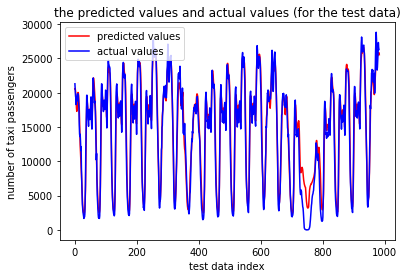

In [20]:
# plot the predicted values and actual values
plot_result(test_df, pred_df)

## 4. save and restore

We provide save and restore interface to save the pipeline with the best trial for easily rebuilding.

In [21]:
# save the pipeline with best trial
saved_pipeline_file = "../../../saved_pipeline/"
pipeline.save(saved_pipeline_file)

In [22]:
# create a new pipeline and specify the pipeline path to restore
from zoo.automl.pipeline.time_sequence import TimeSequencePipeline

new_pipeline = TimeSequencePipeline()
new_pipeline.restore(saved_pipeline_file)

Initialize time sequence pipeline.


In [27]:
# you can do predict and evaluate again
# to compare results before and after restore, we use test_df as input
new_pred = new_pipeline.predict(test_df)

In [28]:
new_pred.head(5)

,datetime,value
0,2015-01-11 13:00:00,20563.957031
1,2015-01-11 13:30:00,20617.906250
2,2015-01-11 14:00:00,20218.281250
3,2015-01-11 14:30:00,19494.654297
4,2015-01-11 15:00:00,18734.599609


In [25]:
# evaluate test_df
mse, rs = new_pipeline.evaluate(test_df, metric=["mean_squared_error", "r_square"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the r_square value is", rs)

Evaluate: the mean square error is 0.053552708938798155
Evaluate: the r_square value is 0.9545420577810749
